In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import add_dummy_feature
import sklearn.metrics as metrics
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

from math import ceil

In [2]:
data = pd.read_csv("bottle.csv")
data.shape

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26504\2475262720.py:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("bottle.csv")


(864863, 74)

## Part A: Data Cleaning

1) We will increase the complexity of our model slightly by increasing the number of features. Keep the following features:

- T_degC (water temperature)
- Salnty (salinity of water)
- STheta (density of water)
- O2ml_L (milliliters of dissolved oxygen per liter of water)
- Depthm (depth in meters)

In [3]:
df = data[['T_degC', 'Salnty', 'STheta', 'O2ml_L', 'Depthm']]
df.columns

Index(['T_degC', 'Salnty', 'STheta', 'O2ml_L', 'Depthm'], dtype='object')

2) Remove NaN / NA values from dataset (prior to building train/test sets) (same as HW #1):

In [4]:
df = df.dropna()
df.shape

(661268, 5)

3) Remove any STheta outliers (same as HW #1).

In [5]:
df[df['STheta'] > 50]

,T_degC,Salnty,STheta,O2ml_L,Depthm


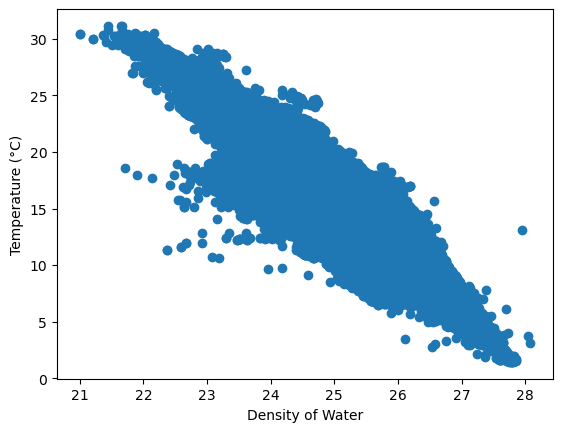

In [6]:
plt.scatter(df['STheta'], df['T_degC'])
plt.xlabel("Density of Water")
plt.ylabel("Temperature (°C)")
plt.show()

There are no outliers. They were dropped when dropping null values

In [7]:
df.shape

(661268, 5)

## Part B: Train / Test Split & Scaling

1) Create X & y objects:

- X object should be all 4 predictors. Shape should be: (661268, 4)

- y object should be just your target variable (T_degC): Shape should be: (661268, 1)

In [8]:
X = df.drop(['T_degC'], axis = 1).to_numpy()
y = df[['T_degC']].to_numpy()
print(X.shape, y.shape)

(661268, 4) (661268, 1)


2) Generate X_train, X_test, y_train & y_test. Use 80% for train & 20% for test.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size= 0.2, random_state=42)

3) Scale all features to improve convergence in Gradient Descent.

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Part C: Linear Regression with sklearn

1) Create an instance of the LinearRegression class called "lin_reg". Fit lin_reg using X_train_scaled & y_train.

In [11]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

2) Print out the coefficients (including the intercept)

In [12]:
lin_reg.coef_, lin_reg.intercept_

(array([[ 1.63046569, -4.6345913 ,  0.3020677 , -0.47495536]]),
 array([10.91541795]))

3) Predict T_degC for the test data using lin_reg. Make sure to use X_test_scaled!

- Call predictions y_pred_sklearn

In [13]:
y_pred_sklearn = lin_reg.predict(X_test_scaled)
y_pred_sklearn

array([[16.68757262],
       [ 8.62255144],
       [10.69854382],
       ...,
       [ 6.16833123],
       [10.94458735],
       [16.36913142]])

4) Calculate the following for the test data:

- mean squared error
- r-squared
- explained variance

In [14]:
mse_sk = metrics.mean_squared_error(y_test, y_pred_sklearn)
r2_sk = metrics.r2_score(y_test, y_pred_sklearn)
ev_sk = metrics.explained_variance_score(y_test, y_pred_sklearn)

pd.DataFrame({'Metric using sklearn': ['Mean Squared Error', 'R-squared', 'Explained Variance'],
              'Score': [mse_sk, r2_sk, ev_sk]})

,Metric using sklearn,Score
0,Mean Squared Error,0.111220
1,R-squared,0.993757
2,Explained Variance,0.993763


5) Create a scatterplot that shows actual versus predicted values for the T_degC.

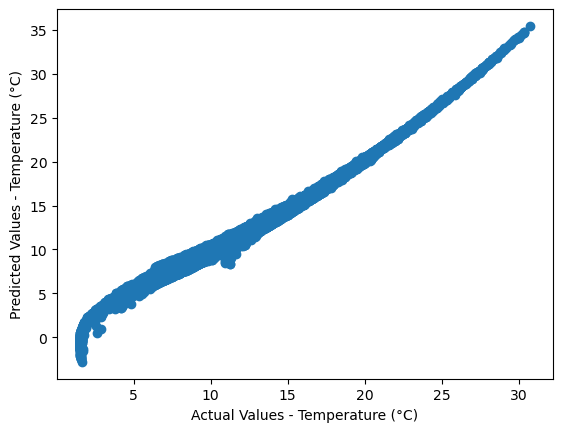

In [15]:
plt.scatter(y_test, y_pred_sklearn)
plt.xlabel("Actual Values - Temperature (°C)")
plt.ylabel("Predicted Values - Temperature (°C)")
plt.show()

## Part D: Gradient Descent Mini-Batch

Please make sure you are using Mini-Batch! Perform the following six steps for mini-batch sizes of: 50, 250, & 2000. Save all outputs

1) Similar to HW #1, you will need to add a column of 1s to X_train_scaled and X_test_scaled.

In [16]:
X_train_scaled_b = add_dummy_feature(X_train_scaled) # add x0 = 1 to each instance
X_test_scaled_b = add_dummy_feature(X_test_scaled) # add x0 = 1 to each instance

2) The cost function we will use for Gradient Descent is MSE (refer to Equation 4-3 in Hands-On Machine Learning Chapter 4).

In [17]:
def minibatch_gradient_descent(minibatch_size):
    eta = 0.1
    n_epochs = 100
    minibatch_size = minibatch_size
    m = len(X_train_scaled_b)
    n_batches_per_epoch = ceil(m / minibatch_size)

    np.random.seed(42)
    theta = np.random.randn(5, 1)  # random initialization

    theta_path_mgd = []
    for epoch in range(n_epochs):
        shuffled_indices = np.random.permutation(m)
        X_b_shuffled = X_train_scaled_b[shuffled_indices]
        y_shuffled = y_train[shuffled_indices]
        for iteration in range(0, n_batches_per_epoch):
            idx = iteration * minibatch_size
            xi = X_b_shuffled[idx : idx + minibatch_size]
            yi = y_shuffled[idx : idx + minibatch_size]
            gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
            theta = theta - eta * gradients
            theta_path_mgd.append(theta)
    
    theta_path_mgd = np.array(theta_path_mgd)
    y_pred_gdm = X_test_scaled_b @ theta
    y_train_gdm = X_train_scaled_b @ theta
    return [y_pred_gdm, y_train_gdm]


In [18]:
# For mini-batch size 100
y_pred_gdm_50, y_train_gdm_50 = minibatch_gradient_descent(50)

# For mini-batch size 250
y_pred_gdm_250, y_train_gdm_250 = minibatch_gradient_descent(250)

# For mini-batch size 2000
y_pred_gdm_2000, y_train_gdm_2000 = minibatch_gradient_descent(2000)


In [19]:
pd.DataFrame(y_pred_gdm_50).to_csv('Mini_Batch_Test_50.csv', index=False)
pd.DataFrame(y_pred_gdm_250).to_csv('Mini_Batch_Test_250.csv', index=False)
pd.DataFrame(y_pred_gdm_2000).to_csv('Mini_Batch_Test_2000.csv', index=False)

pd.DataFrame(y_train_gdm_50).to_csv('Mini_Batch_Train_50.csv', index=False)
pd.DataFrame(y_train_gdm_250).to_csv('Mini_Batch_Train_250.csv', index=False)
pd.DataFrame(y_train_gdm_2000).to_csv('Mini_Batch_Train_2000.csv', index=False)


4) Calculate the following for the test data:

- mean squared error
- r-squared
- explained variance

In [20]:
metrics_df = []
batch_list = {50 : y_pred_gdm_50, 
              250 : y_pred_gdm_250,
              2000 : y_pred_gdm_2000}

for b, y in batch_list.items():
    mse_sk = metrics.mean_squared_error(y_test, y)
    r2_sk = metrics.r2_score(y_test, y)
    ev_sk = metrics.explained_variance_score(y_test, y)

    metrics_df.append([b, mse_sk, r2_sk, ev_sk])

test_data = pd.DataFrame(metrics_df, columns=['Batch size', 'Mean Squared Error', 'R-squared', 'Explained Variance'])
test_data

,Batch size,Mean Squared Error,R-squared,Explained Variance
0,50,0.118163,0.993367,0.993394
1,250,0.112253,0.993699,0.993700
2,2000,0.111122,0.993762,0.993766


5) Create a scatterplot that shows actual versus predicted values for the T_degC for the test data.

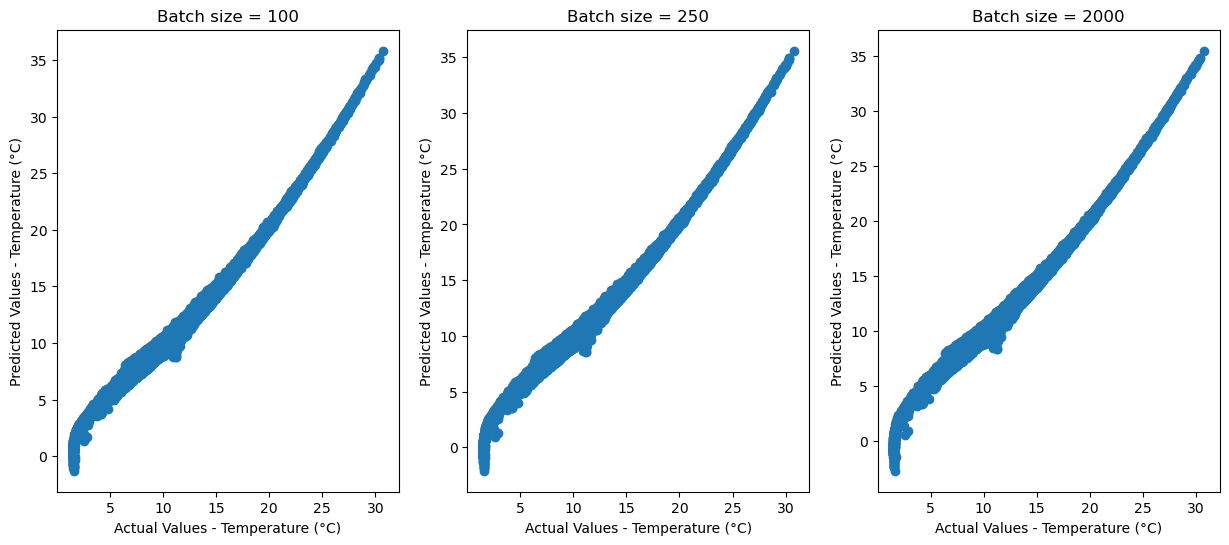

In [21]:
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.scatter(y_test, y_pred_gdm_50)
plt.title("Batch size = 100")
plt.xlabel("Actual Values - Temperature (°C)")
plt.ylabel("Predicted Values - Temperature (°C)")
plt.subplot(132)
plt.scatter(y_test, y_pred_gdm_250)
plt.title("Batch size = 250")
plt.xlabel("Actual Values - Temperature (°C)")
plt.ylabel("Predicted Values - Temperature (°C)")
plt.subplot(133)
plt.scatter(y_test, y_pred_gdm_2000)
plt.title("Batch size = 2000")
plt.xlabel("Actual Values - Temperature (°C)")
plt.ylabel("Predicted Values - Temperature (°C)")
plt.show()

6) Given we are estimating parameters through gradient descent we also want to check how our error metrics look for training data. Calculate the following for the training data:

- mean squared error
- r-squared
- explained variance

In [22]:
metrics_df = []
batch_list = {50 : y_train_gdm_50, 
              250 : y_train_gdm_250,
              2000 : y_train_gdm_2000}

for b, y in batch_list.items():
    mse_sk = metrics.mean_squared_error(y_train, y)
    r2_sk = metrics.r2_score(y_train, y)
    ev_sk = metrics.explained_variance_score(y_train, y)

    metrics_df.append([b, mse_sk, r2_sk, ev_sk])

train_data = pd.DataFrame(metrics_df, columns=['Batch size', 'Mean Squared Error', 'R-squared', 'Explained Variance'])
train_data

,Batch size,Mean Squared Error,R-squared,Explained Variance
0,50,0.118167,0.993382,0.993442
1,250,0.112233,0.993714,0.993727
2,2000,0.110704,0.993800,0.993800


## Part E: Conceptual Questions

<b>1) Describe how parameter estimation in Gradient Descent differs from using the normal equation.</b>
- Gradient descent takes an iterative approach where the parameters are updated gradually until convergence.
- Gradient descent requires us to define a learning rate that controls the size of the steps taken towards the minimum loss function. While the normal equation doesn’t require us to define a learning rate because we are not taking iterative steps - we get the results directly.

<b>2) We used Mini-Batch Gradient descent here, but there are a variety of options for Gradient Descent. How is Mini-Batch Gradient Descent different from Stochastic Gradient Descent?</b>
- The main difference between Mini-Batch Gradient Descent (MBGD) and Stochastic Gradient Descent (SGD) is the size of the set of training examples used to update the model parameters, with SGD using a single example and MBGD using a small random subset.
- MBGD is less is less noisy than SGD which can help the optimization converge more efficiently.

<b>3) Identify your best-performing version of Gradient Descent and compare the error metrics for test data vs training data. Does this version of gradient descent show signs of overfitting? Explain.</b><br>
Based on the MSE, the model with batch size 2000 seems to be having the lowest and is the best. However, comparing with the errors of the training data set:

In [23]:
df_2 = test_data.merge(train_data, on='Batch size', how='left', suffixes=['_test', '_train'])
df_2['MSE difference'] = abs(df_2['Mean Squared Error_test'] - df_2['Mean Squared Error_train'])
df_2['R-squared difference'] = abs(df_2['R-squared_test'] - df_2['R-squared_train'])
df_2['Explained Variance difference'] = abs(df_2['Explained Variance_test'] - df_2['Explained Variance_train'])

df_2[['Batch size', 'MSE difference', 'R-squared difference', 'Explained Variance difference']]

,Batch size,MSE difference,R-squared difference,Explained Variance difference
0,50,0.000004,0.000015,0.000048
1,250,0.000020,0.000016,0.000027
2,2000,0.000418,0.000038,0.000034


A smaller difference between the predicted values for trained data and test data indicates that the predictions made on the test data are more accurate and closer to the predictions made on the trained data. In this case, a batch size of 50 seems to perform better than a batch size of 2000, which may be causing overfitting since it has the highest difference.

<b>4) Explain what the learning rate is for. Even though we did not, why might it be helpful to change the learning rate over time?</b><br>
The learning rate determines the step size at which the model parameters are updated during optimization.
It might be helpful to change the learning rate over time for the following reasons:
- It can help the model converge faster and prevent getting stuck in suboptimal solutions.
- Changing the learning rate over time is particularly useful in complex or non-convex optimization problems.

<b>5) Why would a data scientist want to use early stopping in gradient descent?</b><br> 
A data scientist may want to use early stopping in gradient descent to prevent overfitting of the model to the training data. Early stopping monitors the validation loss of the model during training and stops the training process when the validation loss stops improving or starts increasing. This prevents the model from becoming too complex and improves its ability to generalize to new data. Early stopping can also reduce the time and computational resources required for training.